# Part1. What this project is about
Although stock price prediction has been around for many years and various methods have been devised, no definitive effective means has yet been developed. If you can predict future stock prices, you can gain great wealth by buying stocks in advance that are expected to rise in price and selling stocks in advance that are expected to fall in price, and not only that, we can also apply this method to various corporate activities.....<br><br>
This project aims to develop models to predict the stock price. This model predicts whether the stock price will rise or not in the following days.<br>
 - Type of learning : Supervised learning<br>
 - Type of task     : Binary classification<br><br>


## Data source
I used the yahoo finance API as a data source. The following data is available in this API (reference : https://pypi.org/project/yfinance/)<br>
 - Stock prices of the target company (high, opening, closing, volume, and adjusted closing prices)
 - Income statements, balance sheets, and cash flow information of the target company
 - Shareholder information of the target company
 - Valuation information of the target company's stock<br>
  etc<br>


In [426]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [427]:
import numpy as np
import itertools
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import train_test_split

import yfinance as yf # yahoo finance API Library
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import datetime as dt
from sklearn.preprocessing import LabelEncoder
import pandas_datareader as web

# Part2. Exploratory Data Analysis(EDA)

In [428]:
# Set data acquisition period
start = '2012-04-26'
end = '2024-04-26'

# Retrieve Microsoft stock data for a specified period of time
ge_data_raw = yf.download('MSFT',start,end)

[*********************100%%**********************]  1 of 1 completed


Data has only 7 columns. (The "Date" Column is a key)<br>
Subsequent work will use the value in the “Close” column, which is the daily closing price of the stock.

In [429]:
ge_data_raw

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-26,32.119999,32.230000,31.920000,32.110001,25.643106,40308100
2012-04-27,32.119999,32.220001,31.879999,31.980000,25.539295,41419100
2012-04-30,31.980000,32.110001,31.920000,32.020000,25.571230,35697200
2012-05-01,32.049999,32.340000,31.950001,32.009998,25.563250,43832300
2012-05-02,31.850000,31.930000,31.639999,31.799999,25.395546,37385300
...,...,...,...,...,...,...
2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,30276500
2024-04-22,400.079987,402.850006,395.750000,400.959991,400.959991,20286900
2024-04-23,404.239990,408.200012,403.059998,407.570007,407.570007,15734500


The data is daily data for 12 years and the number of records is 3019.

In [430]:
ge_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2012-04-26 to 2024-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3019 non-null   float64
 1   High       3019 non-null   float64
 2   Low        3019 non-null   float64
 3   Close      3019 non-null   float64
 4   Adj Close  3019 non-null   float64
 5   Volume     3019 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 165.1 KB


Below is a graphical representation of the stock price trends; the stock price is down in 2022, but has since rallied and is steadily rising.

<Axes: xlabel='Date'>

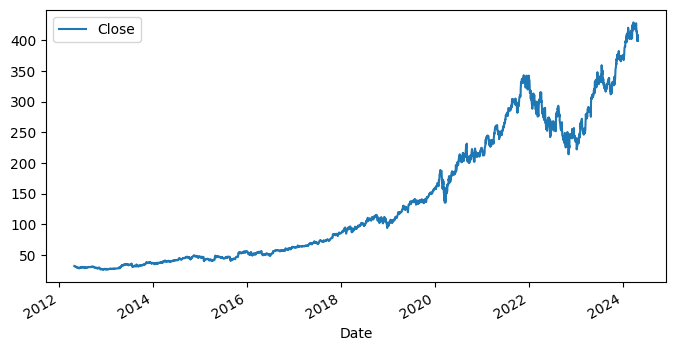

In [431]:
data = pd.DataFrame(ge_data_raw['Close'])
data.plot(figsize=(8,4))

The percentage increase in the stock price from the previous day is also plotted. It is swinging up and down violently.

<Axes: xlabel='Date'>

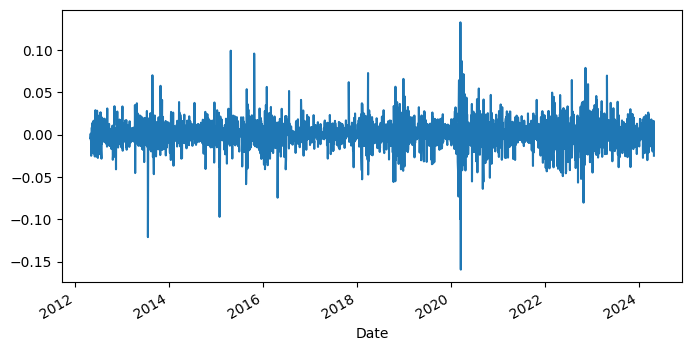

In [432]:
data['return'] = np.log(data['Close']/data['Close'].shift(1))
data.dropna(inplace=True)
data['return'].plot(figsize=(8,4))

# Part3. Model Building① (Logistic Regression Model)
The first step is to create a logistic regression model.<br>
- [Data]<br>  Data from 2012 to 2022 will be used for training and data from 2022 to 2024 for testing. The model uses data from 5 periods of returns, staggered by one day in the period (the 5 previous days are used to forecast a particular day).<br><br>
- [Model Evaluation 1]<br>
 The model predicts whether returns will rise or fall, and Accuracy displays the percentage of correct answers.<br><br>
- [Model Evaluation 2]<br>
I also calculate the virtual trading return following the trading strategy below and compared it to the "return" Column.<br>
 - Take a long position(buy position) when the model predicts an increase<br>
 - Take a short position(sell position) when the model predicts a decrease<br>


In [433]:
LAGS = 5
cols = []
for lag in range(1, LAGS + 1):
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)
print(data.head())

            Close    return     lag_1     lag_2     lag_3     lag_4     lag_5
Date                                                                         
2012-05-04  30.98 -0.024866 -0.001259 -0.006582 -0.000312  0.001250 -0.004057
2012-05-07  30.65 -0.010709 -0.024866 -0.001259 -0.006582 -0.000312  0.001250
2012-05-08  30.50 -0.004906 -0.010709 -0.024866 -0.001259 -0.006582 -0.000312
2012-05-09  30.76  0.008488 -0.004906 -0.010709 -0.024866 -0.001259 -0.006582
2012-05-10  30.74 -0.000650  0.008488 -0.004906 -0.010709 -0.024866 -0.001259


In [434]:
CUTOFF = '2022-04-26'
data['direction'] = np.where(data['return']>0, 1, 0)

training_data0 = data[data.index < CUTOFF].copy()
test_data0 = data[data.index >= CUTOFF].copy()

In [435]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',multi_class='auto',max_iter=1000)
lm.fit(training_data0[cols], training_data0['direction'])
pred = lm.predict(training_data0[cols])
training_data0['predict'] = np.where(pred > 0, 1, -1)
training_data0['return_VirtualTrading'] = (training_data0['predict'] * training_data0['return'])

### For Train Data

In [436]:
accuracy_score(lm.predict(training_data0[cols]), training_data0['direction'])

0.5446215139442231

<Axes: xlabel='Date'>

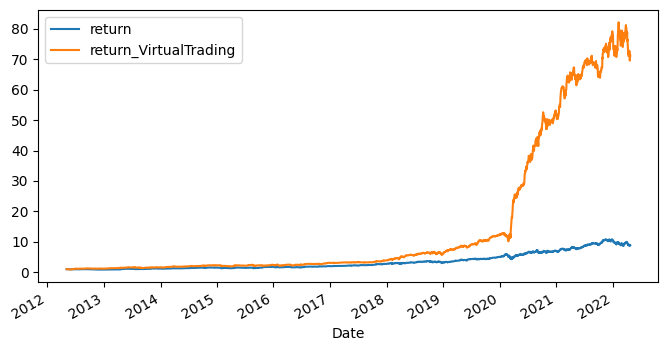

In [437]:
training_data0[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

### For Test Data

In [438]:
accuracy_score(lm.predict(test_data0[cols]), test_data0['direction'])

0.4990059642147117

<Axes: xlabel='Date'>

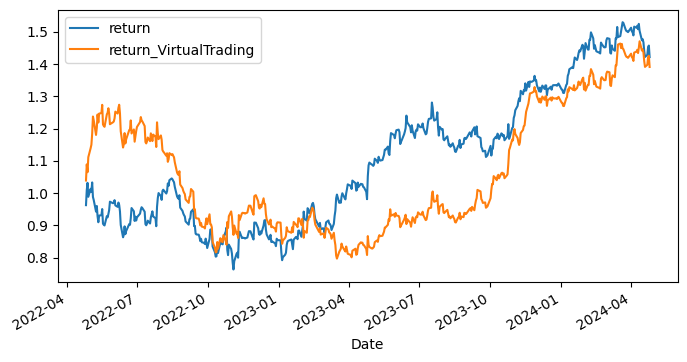

In [439]:
pred = np.where(lm.predict(test_data0[cols]) > 0.5, 1, 0)

test_data0['predict'] = np.where(pred > 0, 1, -1)
test_data0['return_VirtualTrading'] = (test_data0['predict'] * test_data0['return'])
test_data0[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

-> For the test data, accuracy was slightly below 50% and virtual trading return was also slightly below those in the return column.

# Part4. Model Building② (Deep Learning Model)
Next, I created a deep learning model. The using data and the model evaluation was similar to that of the logistic regression model.

In [440]:
CUTOFF = '2022-04-26'
data['direction'] = np.where(data['return']>0, 1, 0)

training_data = data[data.index < CUTOFF].copy()
#mu, std = training_data.mean(), training_data.std()
#training_data_t = (training_data - mu)/std

test_data = data[data.index >= CUTOFF].copy()
#test_data_t = (test_data - mu)/std

<Axes: >

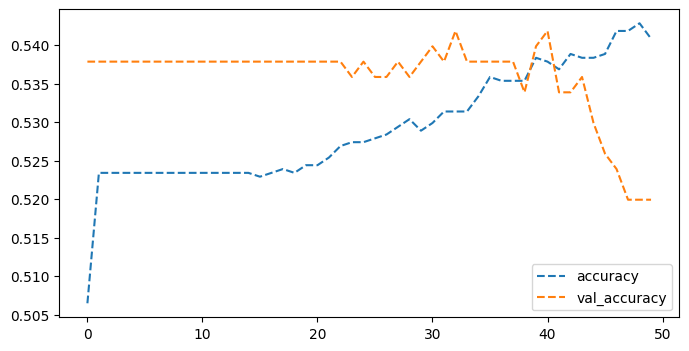

In [441]:
def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

set_seeds()

optimizer = Adam(learning_rate = 0.0001)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(LAGS,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(training_data[cols], training_data['direction'], epochs=50, verbose=False, validation_split=0.2, shuffle=False)

res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(8,4),style='--')

### For Train data

In [442]:
model.evaluate(training_data[cols], training_data['direction'])

79/79 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5375


[0.6889820694923401, 0.5374501943588257]

79/79 [==============================] - 0s 3ms/step


<Axes: xlabel='Date'>

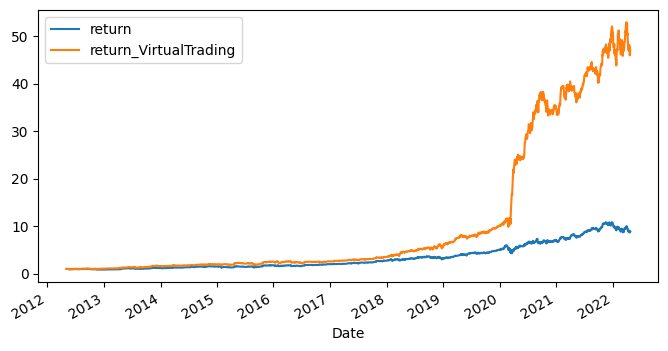

In [443]:
pred = np.where(model.predict(training_data[cols]) > 0.5, 1, 0)

training_data['predict'] = np.where(pred > 0, 1, -1)
training_data['return_VirtualTrading'] = (training_data['predict']*training_data['return'])
#training_data[['return', 'VirtualTrading']].sum().apply(np.exp)
training_data[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

### For Test Data

In [444]:
model.evaluate(test_data[cols], test_data['direction'])

16/16 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.5129


[0.6968005895614624, 0.512922465801239]

16/16 [==============================] - 0s 2ms/step


<Axes: xlabel='Date'>

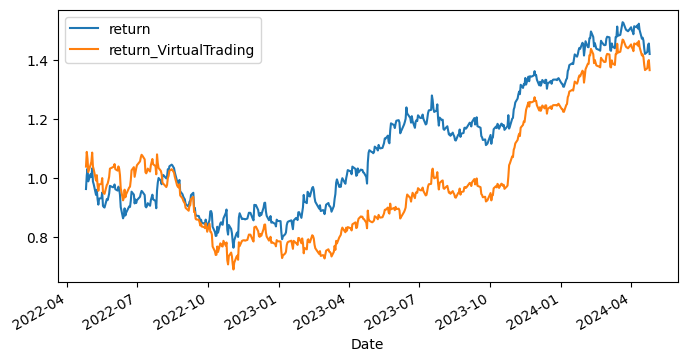

In [445]:
pred = np.where(model.predict(test_data[cols]) > 0.5, 1, 0)

test_data['predict'] = np.where(pred > 0, 1, -1)
test_data['return_VirtualTrading'] = (test_data['predict']*test_data['return'])
#test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

-> Test data accuracy exceeded 50%, but virtual trading return was still below the return column.

# Part5. Model Building③ (LSTM Model)
Next, an LSTM model was created. The method of evaluating the model was the same as the previous one, but I used return data for the past 30 days to take advantage of the characteristics of LSTM model, which allow the use of long-term memory.

In [446]:
def get_standardized_t(X, num_date):
    X = np.array(X)
    X_t_list = []
    for i in range(len(X) - num_date + 1):
        X_t = X[i:i+num_date]
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X_t)
        X_t_list.append(X_standardized)
    return np.array(X_t_list)

LAGS = 30

x_train_t =  get_standardized_t(X=training_data[cols], num_date=LAGS)
x_test_t =  get_standardized_t(X=test_data[cols], num_date=LAGS)

y_train_t = training_data['direction'][ LAGS-1 :]
y_test_t = test_data['direction'][ LAGS-1 :]

#print(x_train_t.shape)
#print(y_train_t.shape)

In [447]:
num_l1 = 100
num_l2 = 20
num_output = 1

model = Sequential()
model.add(LSTM(units=num_l1, activation='tanh', batch_input_shape=(None, LAGS, training_data[cols].shape[1])))
model.add(Dense(num_l2, activation='relu'))
model.add(Dense(num_output, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

result = model.fit(x_train_t, y_train_t, epochs=80, batch_size=24, validation_split = 0.1, shuffle=False)

Epoch 1/80
93/93 [==============================] - 9s 51ms/step - loss: 0.6923 - accuracy: 0.5130 - val_loss: 0.7070 - val_accuracy: 0.5020
Epoch 2/80
93/93 [==============================] - 3s 32ms/step - loss: 0.6907 - accuracy: 0.5358 - val_loss: 0.6998 - val_accuracy: 0.4900
Epoch 3/80
93/93 [==============================] - 3s 27ms/step - loss: 0.6893 - accuracy: 0.5403 - val_loss: 0.7030 - val_accuracy: 0.4940
Epoch 4/80
93/93 [==============================] - 3s 29ms/step - loss: 0.6884 - accuracy: 0.5470 - val_loss: 0.7035 - val_accuracy: 0.5060
Epoch 5/80
93/93 [==============================] - 3s 36ms/step - loss: 0.6875 - accuracy: 0.5529 - val_loss: 0.7047 - val_accuracy: 0.4940
Epoch 6/80
93/93 [==============================] - 4s 38ms/step - loss: 0.6862 - accuracy: 0.5529 - val_loss: 0.7055 - val_accuracy: 0.4900
Epoch 7/80
93/93 [==============================] - 2s 21ms/step - loss: 0.6854 - accuracy: 0.5551 - val_loss: 0.7066 - val_accuracy: 0.4980
Epoch 8/80
93

### For test data

In [448]:
model.evaluate(x_test_t, y_test_t)

15/15 [==============================] - 0s 12ms/step - loss: 2.9463 - accuracy: 0.5169


[2.9463107585906982, 0.5168776512145996]

15/15 [==============================] - 1s 9ms/step


<ipython-input-449-8c3a915ed24f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2['predict'] = np.where(pred > 0, 1, -1)
<ipython-input-449-8c3a915ed24f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2['return_VirtualTrading'] = (test_data2['predict']*test_data2['return'][ LAGS-1 :])


<Axes: xlabel='Date'>

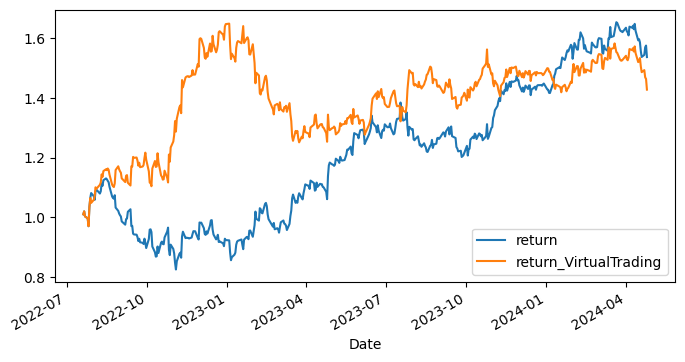

In [449]:
pred = np.where(model.predict(x_test_t) > 0.5, 1, 0)

test_data2 = test_data[ LAGS-1 :]
test_data2['predict'] = np.where(pred > 0, 1, -1)
test_data2['return_VirtualTrading'] = (test_data2['predict']*test_data2['return'][ LAGS-1 :])
test_data2[['return', 'return_VirtualTrading']].sum().apply(np.exp)
test_data2[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

-> Test data accuracy exceeded the previous model's accuracy, but virtual trading return was still below the return column.

# Part6. Model Building④ (Using information of the securites firms)
We can also obtain securities firms action infomaion via The Yahoo Finance API.<br>
In this part, I created a new model combining the model in Part 4 (Model Building② (Deep Learning Model)) with the securites firms information.<br>
 - The “Action” of the securities company was used to creat the model.
 - The date of “Action” is shifted by one day. (For example, to predict the stock price on 4/26, the 'Action' of 4/25 is used.)

In [450]:
msft = yf.Ticker("MSFT")
#msft.recommendations
#msft.recommendations_summary
df = msft.upgrades_downgrades

df = df.reset_index()
df['dates'] = df['GradeDate'].apply(lambda x : dt.date(x.year,x.month,x.day))
df

,GradeDate,Firm,ToGrade,FromGrade,Action,dates
0,2024-04-26 18:25:08,Wells Fargo,Overweight,Overweight,main,2024-04-26
1,2024-04-26 17:37:21,Raymond James,Outperform,Outperform,reit,2024-04-26
2,2024-04-26 13:05:32,Wedbush,Outperform,Outperform,reit,2024-04-26
3,2024-04-26 11:46:39,Stifel,Buy,Buy,main,2024-04-26
4,2024-04-26 11:12:49,Goldman Sachs,Buy,Buy,main,2024-04-26
...,...,...,...,...,...,...
680,2012-04-20 10:18:00,Deutsche Bank,Buy,,main,2012-04-20
681,2012-04-03 15:53:00,UBS,Buy,,main,2012-04-03
682,2012-03-22 11:03:00,Morgan Stanley,Overweight,,main,2012-03-22
683,2012-03-19 18:00:00,Hilliard Lyons,Long-Term Buy,,main,2012-03-19


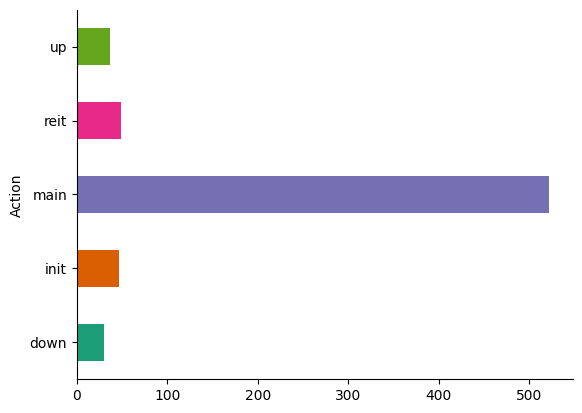

In [451]:
df.groupby('Action').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

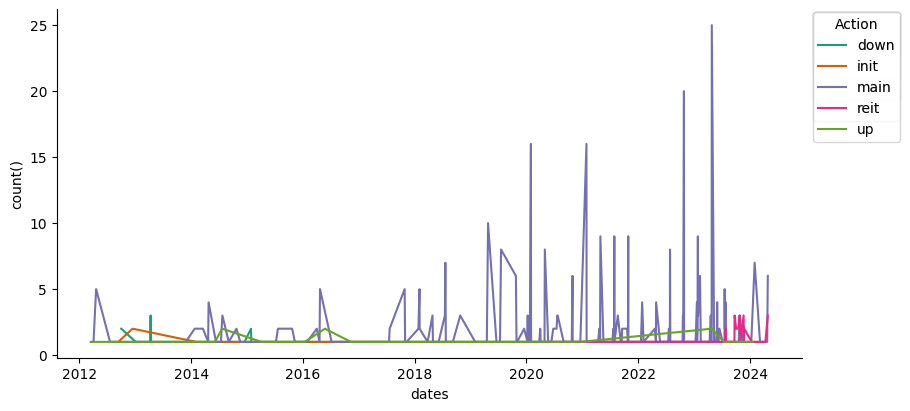

In [452]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['dates'].value_counts().reset_index(name='counts').rename({'index': 'dates'}, axis=1).sort_values('dates', ascending=True))
  xs = counted['dates']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
df_sorted = df.sort_values('dates', ascending=True)

for i, (series_name, series) in enumerate(df_sorted.groupby('Action')):
  _plot_series(series, series_name, i)
  fig.legend(title='Action', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dates')
_ = plt.ylabel('count()')

In [453]:
le = LabelEncoder()
le.fit(df_sorted['Action'])
df_sorted['Action'] = le.transform(df_sorted['Action'])
df_sorted2 = pd.get_dummies(df_sorted[['Action','dates']], columns=['Action'], drop_first=True, dtype='uint8')
df_sorted3 = df_sorted2.groupby('dates').sum()

print(df_sorted3.head())

            Action_1  Action_2  Action_3  Action_4
dates                                             
2012-03-16         0         0         0         1
2012-03-19         0         1         0         0
2012-03-22         0         1         0         0
2012-04-03         0         1         0         0
2012-04-20         0         5         0         0


In [454]:
df_m = pd.merge(data, df_sorted3, how="left", left_index=True, right_index=True)

df_m['Action_1_lag'] = df_m['Action_1'].shift(1)
df_m['Action_2_lag'] = df_m['Action_2'].shift(1)
df_m['Action_3_lag'] = df_m['Action_3'].shift(1)
df_m['Action_4_lag'] = df_m['Action_4'].shift(1)

df_m = df_m.dropna(subset=['Close'])
df_m = df_m.fillna(0)
print(df_m.isnull().sum())

Close           0
return          0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
direction       0
Action_1        0
Action_2        0
Action_3        0
Action_4        0
Action_1_lag    0
Action_2_lag    0
Action_3_lag    0
Action_4_lag    0
dtype: int64


In [455]:
df_m = df_m.reset_index()
df_m['Date'] = pd.to_datetime(df_m['Date'], format='%Y-%m-%d')
df_m = df_m.set_index('Date')

In [456]:
CUTOFF = '2022-04-26'
df_m['direction'] = np.where(df_m['return']>0, 1, 0)

training_data2 = df_m[df_m.index < CUTOFF].copy()
mu, std = training_data2.mean(), training_data2.std()
training_data_t2 = (training_data2 - mu)/std

test_data2 = df_m[df_m.index >= CUTOFF].copy()
test_data_t2 = (test_data2 - mu)/std

In [457]:
training_data2.tail(10)

,Close,return,lag_1,lag_2,lag_3,lag_4,lag_5,direction,Action_1,Action_2,Action_3,Action_4,Action_1_lag,Action_2_lag,Action_3_lag,Action_4_lag
Date,,,,,,,,,,,,,,,,
2022-04-11,285.260010,-0.040230,-0.014708,0.006224,-0.037293,-0.013070,0.017778,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-12,282.059998,-0.011281,-0.040230,-0.014708,0.006224,-0.037293,-0.013070,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-13,287.619995,0.019520,-0.011281,-0.040230,-0.014708,0.006224,-0.037293,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-14,279.829987,-0.027458,0.019520,-0.011281,-0.040230,-0.014708,0.006224,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-18,280.519989,0.002463,-0.027458,0.019520,-0.011281,-0.040230,-0.014708,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-19,285.299988,0.016896,0.002463,-0.027458,0.019520,-0.011281,-0.040230,1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-20,286.359985,0.003708,0.016896,0.002463,-0.027458,0.019520,-0.011281,1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2022-04-21,280.809998,-0.019571,0.003708,0.016896,0.002463,-0.027458,0.019520,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-22,274.029999,-0.024441,-0.019571,0.003708,0.016896,0.002463,-0.027458,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [458]:
optimizer = Adam(learning_rate = 0.0001)

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

LAGS = 5
cols = []
for lag in range(1, LAGS + 1):
  col = f'lag_{lag}'
  cols.append(col)

for c in range(1, 5):
  col = f'Action_{c}_lag'
  cols.append(col)

set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(training_data2[cols], training_data2['direction'], epochs=50, verbose=False, validation_split=0.2, shuffle=False)

<Axes: >

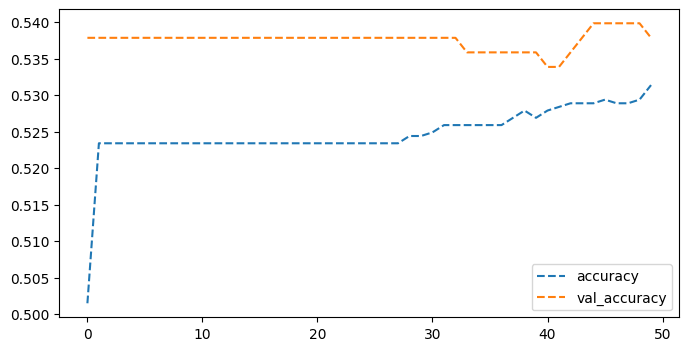

In [459]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(8,4),style='--')

### For test data

In [460]:
model.evaluate(test_data2[cols], test_data2['direction'])

16/16 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5129


[0.6948722004890442, 0.512922465801239]

16/16 [==============================] - 0s 2ms/step


<Axes: xlabel='Date'>

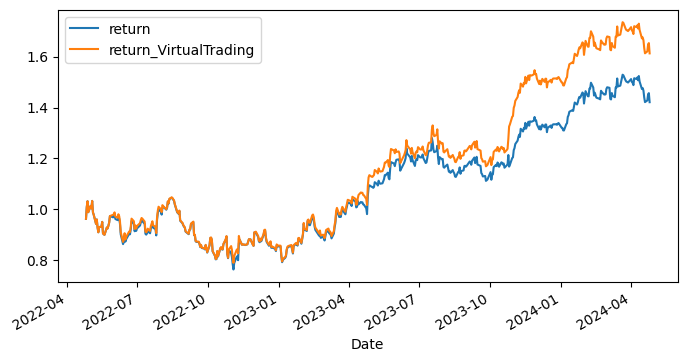

In [461]:
pred = np.where(model.predict(test_data2[cols]) > 0.5, 1, 0)

test_data2['predict'] = np.where(pred > 0, 1, -1)
test_data2['return_VirtualTrading'] = (test_data2['predict'] * test_data2['return'])
test_data2[['return', 'return_VirtualTrading']].dropna().cumsum().apply(np.exp).plot(figsize=(8,4))

-> The accuracy of the test data exceeded 50% and the virtual trading returns finally exceeded the return column !!!

# Part7. Application of the model to other company stocks (The constituents of the Dow Jones Industrial Average Index)
Finally, the model in Part 6 is applied to other stocks in the Dow Jones constituents.

In [462]:
data_sym = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
data_sym = data_sym[1]
data_sym = data_sym[['Company', 'Symbol']]
print(data_sym)

               Company Symbol
0                   3M    MMM
1     American Express    AXP
2                Amgen   AMGN
3               Amazon   AMZN
4                Apple   AAPL
5               Boeing     BA
6          Caterpillar    CAT
7              Chevron    CVX
8                Cisco   CSCO
9            Coca-Cola     KO
10              Disney    DIS
11                 Dow    DOW
12       Goldman Sachs     GS
13          Home Depot     HD
14           Honeywell    HON
15                 IBM    IBM
16               Intel   INTC
17   Johnson & Johnson    JNJ
18      JPMorgan Chase    JPM
19          McDonald's    MCD
20               Merck    MRK
21           Microsoft   MSFT
22                Nike    NKE
23    Procter & Gamble     PG
24          Salesforce    CRM
25           Travelers    TRV
26  UnitedHealth Group    UNH
27             Verizon     VZ
28                Visa      V
29             Walmart    WMT


In [463]:
sym = []

for i in range(len(data_sym)):
  sym.append(data_sym['Symbol'].loc[i])

print(sym)


['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT']


[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 2ms/step


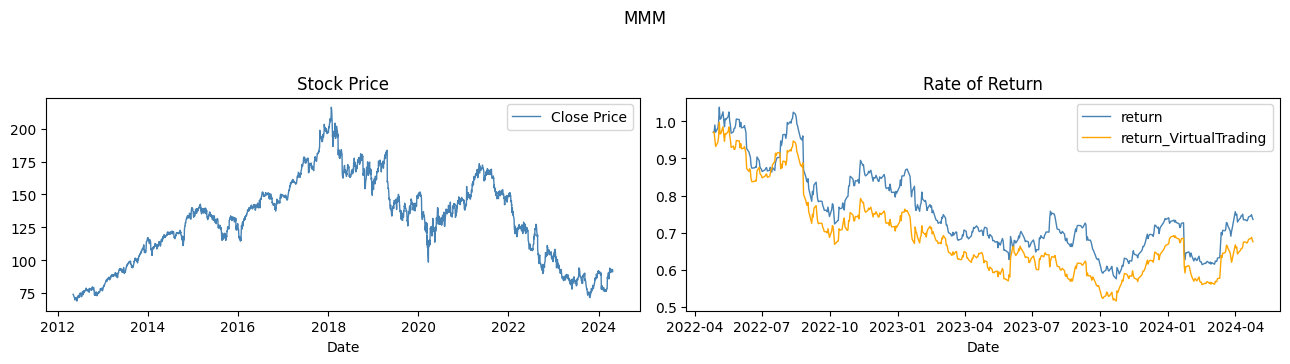

[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 2ms/step


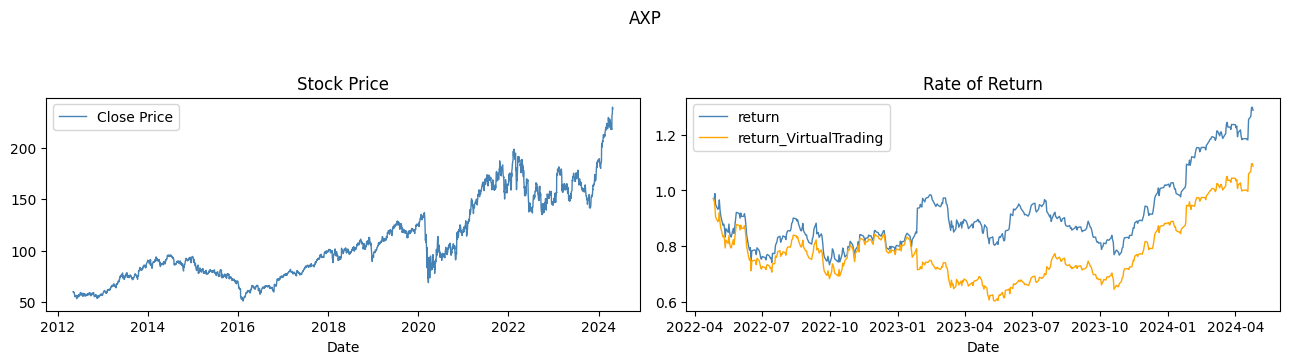

[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 2ms/step


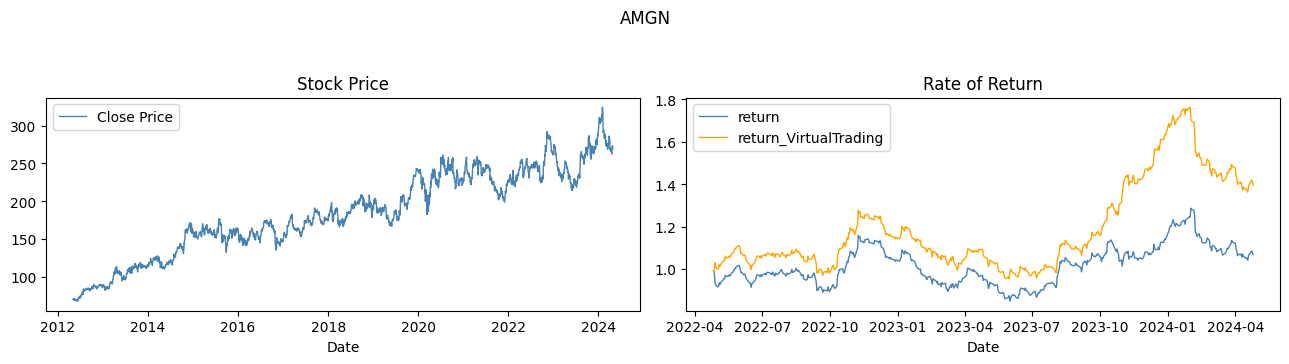

[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 2ms/step


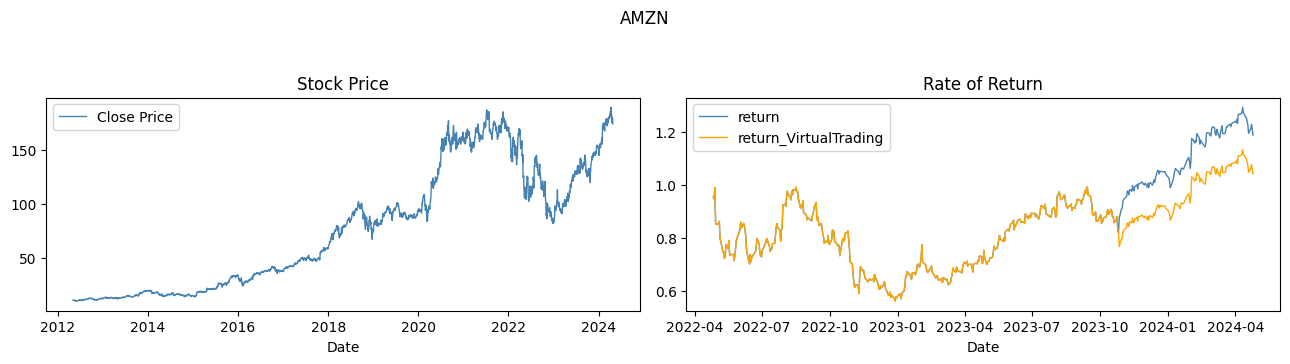

[*********************100%%**********************]  1 of 1 completed


16/16 [==============================] - 0s 2ms/step


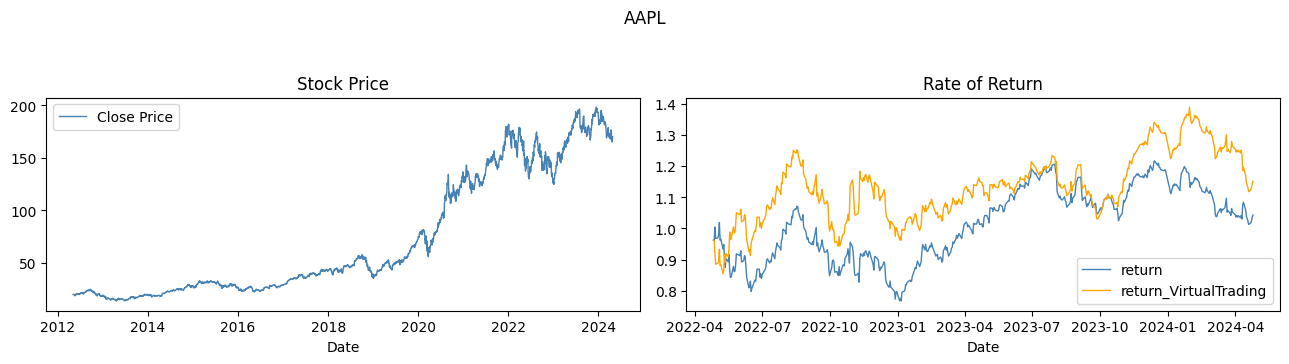

In [465]:
# Limit the number of companies to five because Github omits long codes. All can be calculated.
sym = ['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL']

for i in sym:
  ge_data_raw = yf.download(i,start,end)
  data = pd.DataFrame(ge_data_raw['Close'])

  data['return'] = np.log(data['Close']/data['Close'].shift(1))
  data.dropna(inplace=True)
  LAGS = 5
  cols = []
  for lag in range(1, LAGS + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
  data.dropna(inplace=True)

  msft = yf.Ticker(i)
  df = msft.upgrades_downgrades
  df = df.reset_index()
  df['dates'] = df['GradeDate'].apply(lambda x : dt.date(x.year,x.month,x.day))

  le = LabelEncoder()
  le.fit(df_sorted['Action'])
  df_sorted['Action'] = le.transform(df_sorted['Action'])
  df_sorted2 = pd.get_dummies(df_sorted[['Action','dates']], columns=['Action'], drop_first=True, dtype='uint8')
  df_sorted3 = df_sorted2.groupby('dates').sum()

  df_m = pd.merge(data, df_sorted3, how="left", left_index=True, right_index=True)
  df_m['Action_1_lag'] = df_m['Action_1'].shift(1)
  df_m['Action_2_lag'] = df_m['Action_2'].shift(1)
  df_m['Action_3_lag'] = df_m['Action_3'].shift(1)
  df_m['Action_4_lag'] = df_m['Action_4'].shift(1)
  df_m = df_m.dropna(subset=['Close'])
  df_m = df_m.fillna(0)

  df_m = df_m.reset_index()
  df_m['Date'] = pd.to_datetime(df_m['Date'], format='%Y-%m-%d')
  df_m = df_m.set_index('Date')

  CUTOFF = '2022-04-26'
  df_m['direction'] = np.where(df_m['return']>0, 1, 0)
  training_data2 = df_m[df_m.index < CUTOFF].copy()
  mu, std = training_data2.mean(), training_data2.std()
  training_data_t2 = (training_data2 - mu)/std
  test_data2 = df_m[df_m.index >= CUTOFF].copy()
  test_data_t2 = (test_data2 - mu)/std

  optimizer = Adam(learning_rate = 0.0001)
  LAGS = 5
  cols = []
  for lag in range(1, LAGS + 1):
    col = f'lag_{lag}'
    cols.append(col)

  for c in range(1, 5):
    col = f'Action_{c}_lag'
    cols.append(col)

  set_seeds()
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(len(cols),)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  model.fit(training_data2[cols], training_data2['direction'], epochs=50, verbose=False, validation_split=0.2, shuffle=False)

  model.evaluate(test_data2[cols], test_data2['direction'])
  pred = np.where(model.predict(test_data2[cols]) > 0.5, 1, 0)
  test_data2['predict'] = np.where(pred > 0, 1, -1)
  test_data2['return_VirtualTrading'] = (test_data2['predict'] * test_data2['return'])


  # Create subplots
  fig, ax = plt.subplots(2, 2, figsize=(13, 6))
  fig.suptitle(i)

  # Plot loss scores
  ax[0, 0].set_title("Stock Price")
  ax[0, 0].set_xlabel("Date")
  #ax[0, 0].set_ylabel("Stock Price")
  ax[0, 0].plot(data.index, data['Close'], color="steelblue", lw=1, label="Close Price")
  ax[0, 0].legend()

  # Plot accuracy scores
  ax[0, 1].set_title("Rate of Return")
  ax[0, 1].set_xlabel("Date")

  #ax[0, 1].set_ylabel("Rate of Return")
  ax[0, 1].plot(test_data2.index, test_data2['return'].cumsum().apply(np.exp), color="steelblue", lw=1, label="return")
  ax[0, 1].plot(test_data2.index, test_data2['return_VirtualTrading'].cumsum().apply(np.exp), color="orange", lw=1, label="return_VirtualTrading")
  ax[0, 1].legend()

  # Remove empty subplot
  fig.delaxes(ax[1, 0])
  fig.delaxes(ax[1, 1])

  # Show the plots
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

-> The model outperformed in AMGN and AAPL, but underperformed in MMM, AXP, and AMZN.

# Part8. Discussion and Conclusion
## Conclusion
The following 4 models were created for this project:
- 1) Logistic Regression -----------------------------> test Accuracy: **0.499**,  VirtualReturn: **Underperform**<br>
- 2) Deep Learning ----------------------------------> test Accuracy: **0.513**, VirtualReturn: **Underperform**<br>
- 3) LSTM --------------------------------------------> test Accuracy: **0.517**, VirtualReturn: **Underperform**<br>
- 4) Deep Learning + addtional information -----> test Accuracy: **0.513**, VirtualReturn: **Outperform**<br>


The LSTM model is the most accurate on the test data, but the difference is marginal, while “Deep Learning + addtional information” seems to be the best fit as it is the only one that significantly outperforms. Model 4 was applied to five Dow Jones components in addition to Microsoft, and it outperformed for AMGN and AAPL, but underperformed for MMM, AXP, and AMZN.

## Discussion
 Although I was not able to try it this time due to time constraints, the following point seem to be effective in improving accuracy in the future:<br>
 - Addition of securities firms information to the LSTM model.
